## Imports

In [1]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor

from tqdm import tqdm
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## RLE-Mask utility functions

In [2]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

## Dataloader

In [3]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    # df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader


## Some more utility functions

Dice and IoU metric implementations, metric logger for training and validation.

In [4]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

#         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
#         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
#         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


## Model Initialization

In [5]:
from segmentation_models_pytorch import Unet
model = Unet("resnet18", encoder_weights="imagenet", classes=4, activation=None)
model.cuda()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Training and Validation

In [6]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.num_workers = 6
        self.batch_size = {"train": 16, "val": 16}
        self.accumulation_steps = 16 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 20
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()


In [7]:
sample_submission_path = './severstal-steel-defect-detection/sample_submission.csv'
train_df_path = './severstal-steel-defect-detection/train.csv'
data_folder = "./severstal-steel-defect-detection/"
test_data_folder = "./severstal-steel-defect-detection/test_images"

In [8]:
model_trainer = Trainer(model)
model_trainer.start()

  0%|          | 0/334 [00:00<?, ?it/s]

Starting epoch: 0 | phase: train | ⏰: 13:55:20


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.1409 | IoU: 0.2656 | dice: 0.3569 | dice_neg: nan | dice_pos: 0.3569
Starting epoch: 0 | phase: val | ⏰: 14:03:53


100%|██████████| 84/84 [00:59<00:00,  1.41it/s]


Loss: 0.0357 | IoU: 0.3020 | dice: 0.4048 | dice_neg: nan | dice_pos: 0.4048
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 1 | phase: train | ⏰: 14:04:53


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0314 | IoU: 0.3708 | dice: 0.4812 | dice_neg: nan | dice_pos: 0.4812
Starting epoch: 1 | phase: val | ⏰: 14:13:10


100%|██████████| 84/84 [00:56<00:00,  1.48it/s]


Loss: 0.0296 | IoU: 0.2990 | dice: 0.3917 | dice_neg: nan | dice_pos: 0.3917
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 2 | phase: train | ⏰: 14:14:07


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0269 | IoU: 0.3943 | dice: 0.5030 | dice_neg: nan | dice_pos: 0.5030
Starting epoch: 2 | phase: val | ⏰: 14:22:04


100%|██████████| 84/84 [00:58<00:00,  1.44it/s]


Loss: 0.0236 | IoU: 0.4358 | dice: 0.5434 | dice_neg: nan | dice_pos: 0.5434
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 3 | phase: train | ⏰: 14:23:03


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0247 | IoU: 0.4114 | dice: 0.5194 | dice_neg: nan | dice_pos: 0.5194
Starting epoch: 3 | phase: val | ⏰: 14:31:20


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0276 | IoU: 0.3985 | dice: 0.5032 | dice_neg: nan | dice_pos: 0.5032

Starting epoch: 4 | phase: train | ⏰: 14:32:22


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0229 | IoU: 0.4329 | dice: 0.5409 | dice_neg: nan | dice_pos: 0.5409
Starting epoch: 4 | phase: val | ⏰: 14:40:41


100%|██████████| 84/84 [00:58<00:00,  1.44it/s]


Loss: 0.0229 | IoU: 0.3752 | dice: 0.4709 | dice_neg: nan | dice_pos: 0.4709
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 5 | phase: train | ⏰: 14:41:39


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0227 | IoU: 0.4309 | dice: 0.5387 | dice_neg: nan | dice_pos: 0.5387
Starting epoch: 5 | phase: val | ⏰: 14:49:49


100%|██████████| 84/84 [00:57<00:00,  1.46it/s]


Loss: 0.0227 | IoU: 0.4019 | dice: 0.5080 | dice_neg: nan | dice_pos: 0.5080
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 6 | phase: train | ⏰: 14:50:47


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0215 | IoU: 0.4399 | dice: 0.5473 | dice_neg: nan | dice_pos: 0.5473
Starting epoch: 6 | phase: val | ⏰: 14:59:01


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0255 | IoU: 0.4268 | dice: 0.5338 | dice_neg: nan | dice_pos: 0.5338

Starting epoch: 7 | phase: train | ⏰: 15:00:00


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0203 | IoU: 0.4552 | dice: 0.5625 | dice_neg: nan | dice_pos: 0.5625
Starting epoch: 7 | phase: val | ⏰: 15:08:18


100%|██████████| 84/84 [00:58<00:00,  1.44it/s]


Loss: 0.0210 | IoU: 0.4344 | dice: 0.5404 | dice_neg: nan | dice_pos: 0.5404
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 8 | phase: train | ⏰: 15:09:17


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0193 | IoU: 0.4645 | dice: 0.5717 | dice_neg: nan | dice_pos: 0.5717
Starting epoch: 8 | phase: val | ⏰: 15:17:36


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0217 | IoU: 0.4605 | dice: 0.5642 | dice_neg: nan | dice_pos: 0.5642

Starting epoch: 9 | phase: train | ⏰: 15:18:33


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0187 | IoU: 0.4717 | dice: 0.5779 | dice_neg: nan | dice_pos: 0.5779
Starting epoch: 9 | phase: val | ⏰: 15:26:51


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0216 | IoU: 0.4234 | dice: 0.5291 | dice_neg: nan | dice_pos: 0.5291

Starting epoch: 10 | phase: train | ⏰: 15:27:52


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0181 | IoU: 0.4797 | dice: 0.5873 | dice_neg: nan | dice_pos: 0.5873
Starting epoch: 10 | phase: val | ⏰: 15:35:59


100%|██████████| 84/84 [01:01<00:00,  1.36it/s]


Loss: 0.0196 | IoU: 0.4777 | dice: 0.5954 | dice_neg: nan | dice_pos: 0.5954
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 11 | phase: train | ⏰: 15:37:01


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0175 | IoU: 0.5049 | dice: 0.6208 | dice_neg: nan | dice_pos: 0.6208
Starting epoch: 11 | phase: val | ⏰: 15:45:07


100%|██████████| 84/84 [00:56<00:00,  1.47it/s]


Loss: 0.0194 | IoU: 0.5100 | dice: 0.6258 | dice_neg: nan | dice_pos: 0.6258
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 12 | phase: train | ⏰: 15:46:05


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0183 | IoU: 0.5139 | dice: 0.6321 | dice_neg: nan | dice_pos: 0.6321
Starting epoch: 12 | phase: val | ⏰: 15:54:20


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0233 | IoU: 0.3823 | dice: 0.5080 | dice_neg: nan | dice_pos: 0.5080

Starting epoch: 13 | phase: train | ⏰: 15:55:17


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0166 | IoU: 0.5312 | dice: 0.6501 | dice_neg: nan | dice_pos: 0.6501
Starting epoch: 13 | phase: val | ⏰: 16:03:19


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0202 | IoU: 0.4877 | dice: 0.6063 | dice_neg: nan | dice_pos: 0.6063

Starting epoch: 14 | phase: train | ⏰: 16:04:15


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0157 | IoU: 0.5447 | dice: 0.6641 | dice_neg: nan | dice_pos: 0.6641
Starting epoch: 14 | phase: val | ⏰: 16:12:25


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0202 | IoU: 0.5035 | dice: 0.6226 | dice_neg: nan | dice_pos: 0.6226

Starting epoch: 15 | phase: train | ⏰: 16:13:22


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0151 | IoU: 0.5585 | dice: 0.6778 | dice_neg: nan | dice_pos: 0.6778
Starting epoch: 15 | phase: val | ⏰: 16:21:28


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0209 | IoU: 0.5021 | dice: 0.6220 | dice_neg: nan | dice_pos: 0.6220
Epoch    16: reducing learning rate of group 0 to 5.0000e-05.

Starting epoch: 16 | phase: train | ⏰: 16:22:30


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0127 | IoU: 0.6009 | dice: 0.7176 | dice_neg: nan | dice_pos: 0.7176
Starting epoch: 16 | phase: val | ⏰: 16:30:46


100%|██████████| 84/84 [00:57<00:00,  1.46it/s]


Loss: 0.0181 | IoU: 0.5496 | dice: 0.6706 | dice_neg: nan | dice_pos: 0.6706
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 17 | phase: train | ⏰: 16:31:44


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0120 | IoU: 0.6139 | dice: 0.7283 | dice_neg: nan | dice_pos: 0.7283
Starting epoch: 17 | phase: val | ⏰: 16:40:00


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0186 | IoU: 0.5490 | dice: 0.6698 | dice_neg: nan | dice_pos: 0.6698

Starting epoch: 18 | phase: train | ⏰: 16:41:02


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0116 | IoU: 0.6205 | dice: 0.7345 | dice_neg: nan | dice_pos: 0.7345
Starting epoch: 18 | phase: val | ⏰: 16:49:13


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0191 | IoU: 0.5436 | dice: 0.6653 | dice_neg: nan | dice_pos: 0.6653

Starting epoch: 19 | phase: train | ⏰: 16:50:14


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0112 | IoU: 0.6261 | dice: 0.7388 | dice_neg: nan | dice_pos: 0.7388
Starting epoch: 19 | phase: val | ⏰: 16:58:25


100%|██████████| 84/84 [00:57<00:00,  1.46it/s]

Loss: 0.0194 | IoU: 0.5476 | dice: 0.6690 | dice_neg: nan | dice_pos: 0.6690



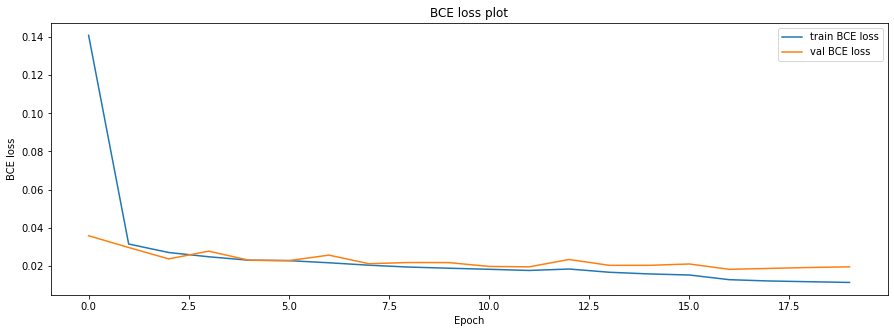

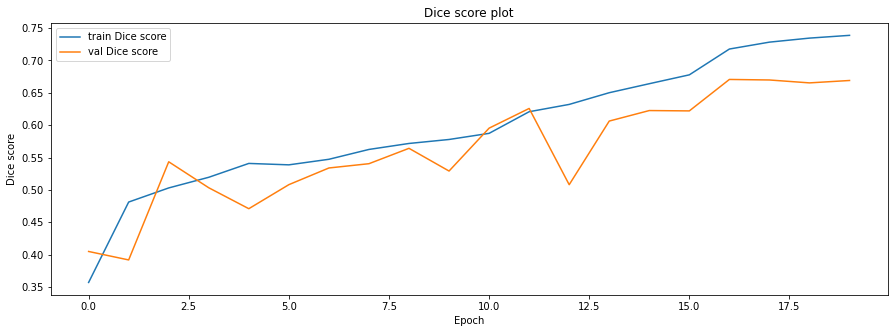

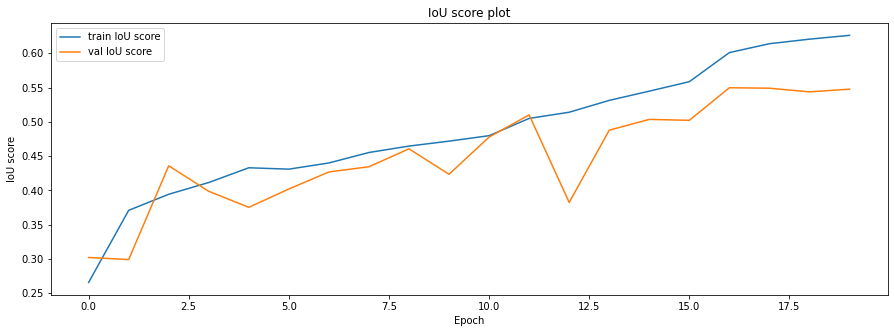

{'train': [0.14092450871684414, 0.031377821982263805, 0.02692270062551527, 0.024682937914918282, 0.022885970570548565, 0.02265646449753089, 0.02153518591578046, 0.02025642876184272, 0.019278412919023078, 0.018669286742806435, 0.018114798363510095, 0.01749548555803513, 0.018253840402906348, 0.01655738226634389, 0.015671883237096455, 0.01511402234217587, 0.012655680217016154, 0.011970192729356047, 0.011587451779545692, 0.011206571248354402], 'val': [0.03573708834924868, 0.02955333907378926, 0.02356993871563602, 0.027625080641536487, 0.02288967199135749, 0.022669203845517977, 0.025545908193591805, 0.0210470045207157, 0.021668099088683015, 0.021623346400225445, 0.019610273019809808, 0.019402176862405168, 0.02325083937362901, 0.020194215572527832, 0.020190174103758875, 0.020897235932006014, 0.01808692907382335, 0.018579550275933884, 0.019053610424245044, 0.019404741918801198]}
{'train': [0.3569189931221527, 0.48117348494912016, 0.5029862518472904, 0.5194444403366548, 0.5408532591303843, 0.5

In [10]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

print(losses)
print(dice_scores)
print(iou_scores)

In [11]:
model_trainer = Trainer(model)
model_trainer.start()

  0%|          | 0/334 [00:00<?, ?it/s]

Starting epoch: 0 | phase: train | ⏰: 17:28:55


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0138 | IoU: 0.5778 | dice: 0.6948 | dice_neg: nan | dice_pos: 0.6948
Starting epoch: 0 | phase: val | ⏰: 17:37:03


100%|██████████| 84/84 [01:00<00:00,  1.38it/s]


Loss: 0.0203 | IoU: 0.5203 | dice: 0.6443 | dice_neg: nan | dice_pos: 0.6443
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 1 | phase: train | ⏰: 17:38:04


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0142 | IoU: 0.5676 | dice: 0.6847 | dice_neg: nan | dice_pos: 0.6847
Starting epoch: 1 | phase: val | ⏰: 17:46:17


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0210 | IoU: 0.4896 | dice: 0.6053 | dice_neg: nan | dice_pos: 0.6053

Starting epoch: 2 | phase: train | ⏰: 17:47:18


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0127 | IoU: 0.5918 | dice: 0.7077 | dice_neg: nan | dice_pos: 0.7077
Starting epoch: 2 | phase: val | ⏰: 17:55:31


100%|██████████| 84/84 [01:01<00:00,  1.37it/s]


Loss: 0.0198 | IoU: 0.5216 | dice: 0.6431 | dice_neg: nan | dice_pos: 0.6431
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 3 | phase: train | ⏰: 17:56:33


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0125 | IoU: 0.5941 | dice: 0.7095 | dice_neg: nan | dice_pos: 0.7095
Starting epoch: 3 | phase: val | ⏰: 18:04:47


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0212 | IoU: 0.5261 | dice: 0.6485 | dice_neg: nan | dice_pos: 0.6485

Starting epoch: 4 | phase: train | ⏰: 18:05:48


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0129 | IoU: 0.5965 | dice: 0.7133 | dice_neg: nan | dice_pos: 0.7133
Starting epoch: 4 | phase: val | ⏰: 18:13:59


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0208 | IoU: 0.5183 | dice: 0.6396 | dice_neg: nan | dice_pos: 0.6396

Starting epoch: 5 | phase: train | ⏰: 18:15:00


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0114 | IoU: 0.6237 | dice: 0.7407 | dice_neg: nan | dice_pos: 0.7407
Starting epoch: 5 | phase: val | ⏰: 18:23:14


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0214 | IoU: 0.5215 | dice: 0.6427 | dice_neg: nan | dice_pos: 0.6427

Starting epoch: 6 | phase: train | ⏰: 18:24:15


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0108 | IoU: 0.6386 | dice: 0.7543 | dice_neg: nan | dice_pos: 0.7543
Starting epoch: 6 | phase: val | ⏰: 18:32:29


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0219 | IoU: 0.5244 | dice: 0.6462 | dice_neg: nan | dice_pos: 0.6462
Epoch     7: reducing learning rate of group 0 to 5.0000e-05.

Starting epoch: 7 | phase: train | ⏰: 18:33:30


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0091 | IoU: 0.6778 | dice: 0.7879 | dice_neg: nan | dice_pos: 0.7879
Starting epoch: 7 | phase: val | ⏰: 18:41:43


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0207 | IoU: 0.5564 | dice: 0.6821 | dice_neg: nan | dice_pos: 0.6821

Starting epoch: 8 | phase: train | ⏰: 18:42:44


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0085 | IoU: 0.6950 | dice: 0.8034 | dice_neg: nan | dice_pos: 0.8034
Starting epoch: 8 | phase: val | ⏰: 18:50:46


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0213 | IoU: 0.5607 | dice: 0.6852 | dice_neg: nan | dice_pos: 0.6852

Starting epoch: 9 | phase: train | ⏰: 18:51:45


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0081 | IoU: 0.7028 | dice: 0.8093 | dice_neg: nan | dice_pos: 0.8093
Starting epoch: 9 | phase: val | ⏰: 18:59:55


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0219 | IoU: 0.5612 | dice: 0.6867 | dice_neg: nan | dice_pos: 0.6867

Starting epoch: 10 | phase: train | ⏰: 19:00:57


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0078 | IoU: 0.7085 | dice: 0.8139 | dice_neg: nan | dice_pos: 0.8139
Starting epoch: 10 | phase: val | ⏰: 19:09:05


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0216 | IoU: 0.5610 | dice: 0.6856 | dice_neg: nan | dice_pos: 0.6856
Epoch    11: reducing learning rate of group 0 to 5.0000e-06.

Starting epoch: 11 | phase: train | ⏰: 19:10:04


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0076 | IoU: 0.7146 | dice: 0.8189 | dice_neg: nan | dice_pos: 0.8189
Starting epoch: 11 | phase: val | ⏰: 19:18:12


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0222 | IoU: 0.5613 | dice: 0.6860 | dice_neg: nan | dice_pos: 0.6860

Starting epoch: 12 | phase: train | ⏰: 19:19:13


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0075 | IoU: 0.7166 | dice: 0.8203 | dice_neg: nan | dice_pos: 0.8203
Starting epoch: 12 | phase: val | ⏰: 19:27:25


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0221 | IoU: 0.5614 | dice: 0.6861 | dice_neg: nan | dice_pos: 0.6861

Starting epoch: 13 | phase: train | ⏰: 19:28:26


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0075 | IoU: 0.7167 | dice: 0.8214 | dice_neg: nan | dice_pos: 0.8214
Starting epoch: 13 | phase: val | ⏰: 19:36:39


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0227 | IoU: 0.5597 | dice: 0.6855 | dice_neg: nan | dice_pos: 0.6855

Starting epoch: 14 | phase: train | ⏰: 19:37:40


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0074 | IoU: 0.7193 | dice: 0.8228 | dice_neg: nan | dice_pos: 0.8228
Starting epoch: 14 | phase: val | ⏰: 19:45:38


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0227 | IoU: 0.5605 | dice: 0.6859 | dice_neg: nan | dice_pos: 0.6859
Epoch    15: reducing learning rate of group 0 to 5.0000e-07.

Starting epoch: 15 | phase: train | ⏰: 19:46:39


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0074 | IoU: 0.7192 | dice: 0.8227 | dice_neg: nan | dice_pos: 0.8227
Starting epoch: 15 | phase: val | ⏰: 19:54:51


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0226 | IoU: 0.5620 | dice: 0.6885 | dice_neg: nan | dice_pos: 0.6885

Starting epoch: 16 | phase: train | ⏰: 19:55:52


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0074 | IoU: 0.7204 | dice: 0.8235 | dice_neg: nan | dice_pos: 0.8235
Starting epoch: 16 | phase: val | ⏰: 20:03:59


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0229 | IoU: 0.5596 | dice: 0.6859 | dice_neg: nan | dice_pos: 0.6859

Starting epoch: 17 | phase: train | ⏰: 20:04:59


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0074 | IoU: 0.7192 | dice: 0.8227 | dice_neg: nan | dice_pos: 0.8227
Starting epoch: 17 | phase: val | ⏰: 20:12:53


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0227 | IoU: 0.5586 | dice: 0.6845 | dice_neg: nan | dice_pos: 0.6845

Starting epoch: 18 | phase: train | ⏰: 20:13:53


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0074 | IoU: 0.7190 | dice: 0.8228 | dice_neg: nan | dice_pos: 0.8228
Starting epoch: 18 | phase: val | ⏰: 20:22:05


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0231 | IoU: 0.5597 | dice: 0.6839 | dice_neg: nan | dice_pos: 0.6839
Epoch    19: reducing learning rate of group 0 to 5.0000e-08.

Starting epoch: 19 | phase: train | ⏰: 20:23:06


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0074 | IoU: 0.7204 | dice: 0.8234 | dice_neg: nan | dice_pos: 0.8234
Starting epoch: 19 | phase: val | ⏰: 20:31:17


100%|██████████| 84/84 [01:00<00:00,  1.38it/s]

Loss: 0.0232 | IoU: 0.5592 | dice: 0.6834 | dice_neg: nan | dice_pos: 0.6834



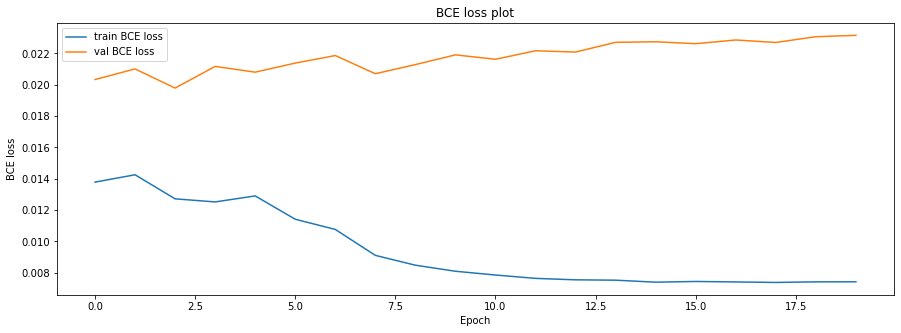

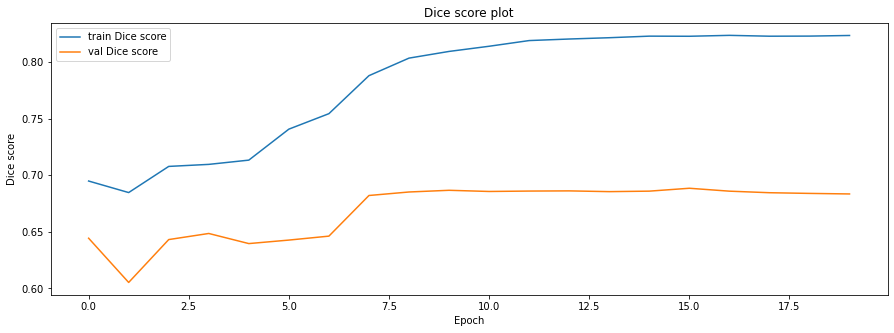

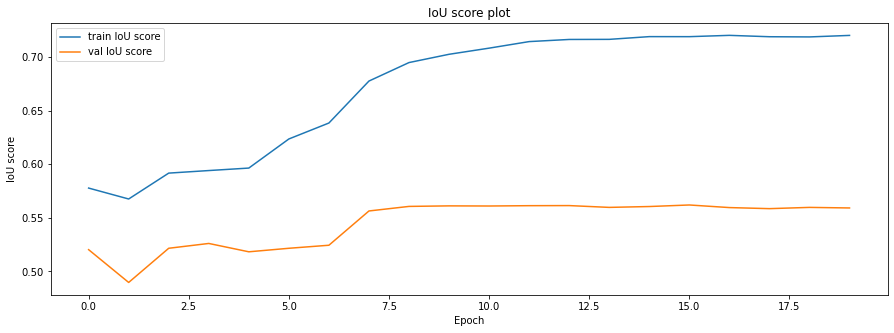

{'train': [0.013780574508089416, 0.014249926685316567, 0.012713480307190807, 0.012515724214173095, 0.012899852901541008, 0.011409704378265106, 0.010759953553035499, 0.009103173236669359, 0.008475531315051778, 0.008089031941190495, 0.007848391427190049, 0.0076337766395826005, 0.007542115388003117, 0.00751846904021515, 0.007391823570712464, 0.007436380073327772, 0.007405897961444261, 0.0073743966613020635, 0.007412221477907932, 0.007415284637590413], 'val': [0.020330959188175343, 0.021008167571077745, 0.019787717682664237, 0.02116799010850844, 0.02080149324389086, 0.02138100445292713, 0.021863898750217187, 0.020702356949359887, 0.021285577400010965, 0.021905645661588227, 0.02162478899671918, 0.02216693365369879, 0.022085956658147984, 0.02270691800818202, 0.022742907888078617, 0.022619235595422133, 0.022855764875809353, 0.02269873730394812, 0.023064588972677786, 0.023152248507055145]}
{'train': [0.6948333722190458, 0.6846509014514325, 0.7077427070962053, 0.7095378441567222, 0.713298427048

In [12]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

print(losses)
print(dice_scores)
print(iou_scores)

In [13]:
model_trainer = Trainer(model)
model_trainer.start()

  0%|          | 0/334 [00:00<?, ?it/s]

Starting epoch: 0 | phase: train | ⏰: 20:43:00


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0105 | IoU: 0.6467 | dice: 0.7619 | dice_neg: nan | dice_pos: 0.7619
Starting epoch: 0 | phase: val | ⏰: 20:50:59


100%|██████████| 84/84 [01:00<00:00,  1.38it/s]


Loss: 0.0216 | IoU: 0.5339 | dice: 0.6571 | dice_neg: nan | dice_pos: 0.6571
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 1 | phase: train | ⏰: 20:52:01


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0095 | IoU: 0.6649 | dice: 0.7772 | dice_neg: nan | dice_pos: 0.7772
Starting epoch: 1 | phase: val | ⏰: 21:00:15


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0248 | IoU: 0.5384 | dice: 0.6628 | dice_neg: nan | dice_pos: 0.6628

Starting epoch: 2 | phase: train | ⏰: 21:01:15


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0111 | IoU: 0.6406 | dice: 0.7559 | dice_neg: nan | dice_pos: 0.7559
Starting epoch: 2 | phase: val | ⏰: 21:09:27


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0238 | IoU: 0.5296 | dice: 0.6532 | dice_neg: nan | dice_pos: 0.6532

Starting epoch: 3 | phase: train | ⏰: 21:10:28


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0088 | IoU: 0.6807 | dice: 0.7899 | dice_neg: nan | dice_pos: 0.7899
Starting epoch: 3 | phase: val | ⏰: 21:18:41


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0235 | IoU: 0.5514 | dice: 0.6782 | dice_neg: nan | dice_pos: 0.6782

Starting epoch: 4 | phase: train | ⏰: 21:19:42


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0082 | IoU: 0.6991 | dice: 0.8069 | dice_neg: nan | dice_pos: 0.8069
Starting epoch: 4 | phase: val | ⏰: 21:27:53


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0239 | IoU: 0.5426 | dice: 0.6689 | dice_neg: nan | dice_pos: 0.6689
Epoch     5: reducing learning rate of group 0 to 5.0000e-05.

Starting epoch: 5 | phase: train | ⏰: 21:28:54


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0072 | IoU: 0.7281 | dice: 0.8299 | dice_neg: nan | dice_pos: 0.8299
Starting epoch: 5 | phase: val | ⏰: 21:37:07


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0233 | IoU: 0.5513 | dice: 0.6766 | dice_neg: nan | dice_pos: 0.6766

Starting epoch: 6 | phase: train | ⏰: 21:38:08


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0066 | IoU: 0.7411 | dice: 0.8395 | dice_neg: nan | dice_pos: 0.8395
Starting epoch: 6 | phase: val | ⏰: 21:46:10


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0235 | IoU: 0.5580 | dice: 0.6851 | dice_neg: nan | dice_pos: 0.6851

Starting epoch: 7 | phase: train | ⏰: 21:47:10


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0064 | IoU: 0.7475 | dice: 0.8440 | dice_neg: nan | dice_pos: 0.8440
Starting epoch: 7 | phase: val | ⏰: 21:55:23


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0247 | IoU: 0.5608 | dice: 0.6882 | dice_neg: nan | dice_pos: 0.6882

Starting epoch: 8 | phase: train | ⏰: 21:56:23


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0061 | IoU: 0.7529 | dice: 0.8481 | dice_neg: nan | dice_pos: 0.8481
Starting epoch: 8 | phase: val | ⏰: 22:04:29


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0254 | IoU: 0.5601 | dice: 0.6872 | dice_neg: nan | dice_pos: 0.6872
Epoch     9: reducing learning rate of group 0 to 5.0000e-06.

Starting epoch: 9 | phase: train | ⏰: 22:05:28


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0060 | IoU: 0.7590 | dice: 0.8526 | dice_neg: nan | dice_pos: 0.8526
Starting epoch: 9 | phase: val | ⏰: 22:13:20


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0257 | IoU: 0.5557 | dice: 0.6808 | dice_neg: nan | dice_pos: 0.6808

Starting epoch: 10 | phase: train | ⏰: 22:14:19


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0058 | IoU: 0.7605 | dice: 0.8535 | dice_neg: nan | dice_pos: 0.8535
Starting epoch: 10 | phase: val | ⏰: 22:22:11


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0260 | IoU: 0.5615 | dice: 0.6885 | dice_neg: nan | dice_pos: 0.6885

Starting epoch: 11 | phase: train | ⏰: 22:23:11


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0058 | IoU: 0.7616 | dice: 0.8545 | dice_neg: nan | dice_pos: 0.8545
Starting epoch: 11 | phase: val | ⏰: 22:31:13


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0254 | IoU: 0.5623 | dice: 0.6887 | dice_neg: nan | dice_pos: 0.6887

Starting epoch: 12 | phase: train | ⏰: 22:32:13


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0058 | IoU: 0.7630 | dice: 0.8555 | dice_neg: nan | dice_pos: 0.8555
Starting epoch: 12 | phase: val | ⏰: 22:40:03


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0257 | IoU: 0.5633 | dice: 0.6907 | dice_neg: nan | dice_pos: 0.6907
Epoch    13: reducing learning rate of group 0 to 5.0000e-07.

Starting epoch: 13 | phase: train | ⏰: 22:41:03


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0058 | IoU: 0.7629 | dice: 0.8552 | dice_neg: nan | dice_pos: 0.8552
Starting epoch: 13 | phase: val | ⏰: 22:48:58


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0257 | IoU: 0.5621 | dice: 0.6883 | dice_neg: nan | dice_pos: 0.6883

Starting epoch: 14 | phase: train | ⏰: 22:49:59


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0058 | IoU: 0.7633 | dice: 0.8559 | dice_neg: nan | dice_pos: 0.8559
Starting epoch: 14 | phase: val | ⏰: 22:58:09


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0253 | IoU: 0.5621 | dice: 0.6884 | dice_neg: nan | dice_pos: 0.6884

Starting epoch: 15 | phase: train | ⏰: 22:59:09


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0057 | IoU: 0.7634 | dice: 0.8558 | dice_neg: nan | dice_pos: 0.8558
Starting epoch: 15 | phase: val | ⏰: 23:07:13


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0259 | IoU: 0.5579 | dice: 0.6861 | dice_neg: nan | dice_pos: 0.6861

Starting epoch: 16 | phase: train | ⏰: 23:08:14


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0058 | IoU: 0.7625 | dice: 0.8553 | dice_neg: nan | dice_pos: 0.8553
Starting epoch: 16 | phase: val | ⏰: 23:16:26


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0260 | IoU: 0.5590 | dice: 0.6852 | dice_neg: nan | dice_pos: 0.6852
Epoch    17: reducing learning rate of group 0 to 5.0000e-08.

Starting epoch: 17 | phase: train | ⏰: 23:17:27


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0057 | IoU: 0.7641 | dice: 0.8566 | dice_neg: nan | dice_pos: 0.8566
Starting epoch: 17 | phase: val | ⏰: 23:25:26


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0256 | IoU: 0.5595 | dice: 0.6881 | dice_neg: nan | dice_pos: 0.6881

Starting epoch: 18 | phase: train | ⏰: 23:26:26


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0057 | IoU: 0.7649 | dice: 0.8575 | dice_neg: nan | dice_pos: 0.8575
Starting epoch: 18 | phase: val | ⏰: 23:34:39


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0258 | IoU: 0.5582 | dice: 0.6849 | dice_neg: nan | dice_pos: 0.6849

Starting epoch: 19 | phase: train | ⏰: 23:35:40


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0057 | IoU: 0.7637 | dice: 0.8560 | dice_neg: nan | dice_pos: 0.8560
Starting epoch: 19 | phase: val | ⏰: 23:43:52


100%|██████████| 84/84 [01:00<00:00,  1.39it/s]

Loss: 0.0263 | IoU: 0.5528 | dice: 0.6792 | dice_neg: nan | dice_pos: 0.6792



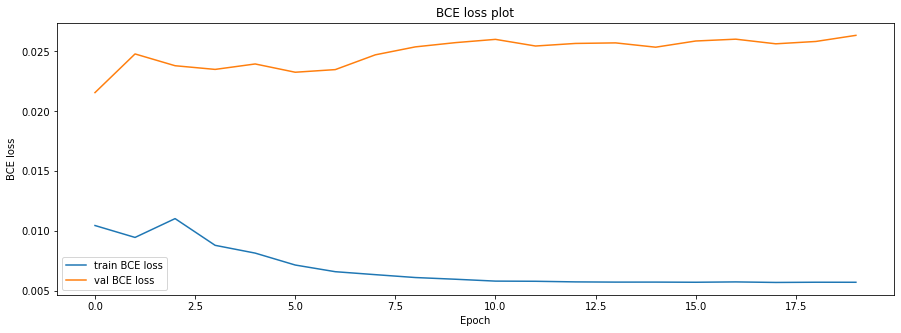

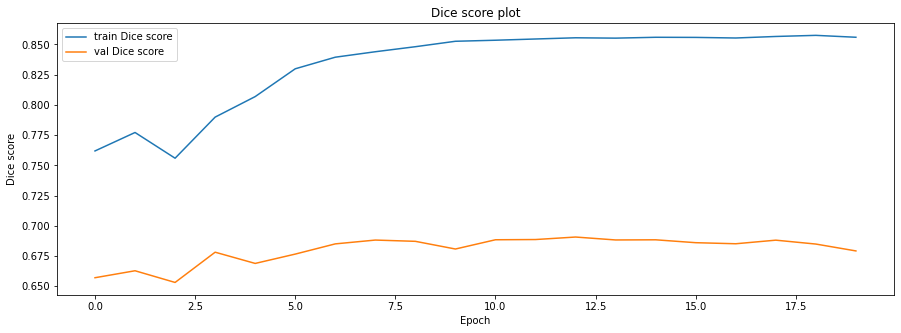

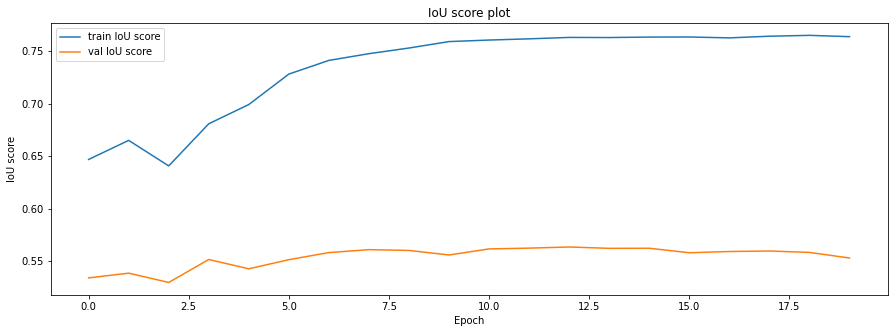

{'train': [0.010476538827810102, 0.009483703819220651, 0.011053062009229186, 0.008825001044723089, 0.008176409786505747, 0.007182499154716239, 0.006626214834158783, 0.006379393013723997, 0.006139422422498019, 0.005997162775142107, 0.00584102394812166, 0.005827279783043631, 0.005776119407985783, 0.0057576316357227765, 0.005758810538832032, 0.005746003516397612, 0.005774449050973008, 0.005729876430760957, 0.005747927069764383, 0.005744588245570794], 'val': [0.02156070798325042, 0.02478489338509029, 0.02380195441877558, 0.02349534315899724, 0.023948717906716325, 0.02325894416952949, 0.023478656153505046, 0.024710920084977432, 0.025374036188059973, 0.02572740993595549, 0.026000348191397887, 0.025445579429201427, 0.025660954077639395, 0.02570622487525855, 0.025347466663723544, 0.02586356474507955, 0.026015804215733494, 0.025629776518880612, 0.025825201012637643, 0.02633462334606087]}
{'train': [0.7619356594364817, 0.7771962609619658, 0.7559239450043129, 0.7899113847840132, 0.806889367732708

In [14]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

print(losses)
print(dice_scores)
print(iou_scores)

## Test prediction and submission

This training and validation takes about ~400 minutes which exceeds Kaggle's GPU usage limit of 60 minutes, we won't be able to submit the `submission.csv` file generated from this kernel. So, for test prediction and submission I've written a separate [UNet inference kernel](https://www.kaggle.com/rishabhiitbhu/unet-pytorch-inference-kernel), make sure you add the `model.pth` file generated from this kernel as dataset to test inference kernel.

I've used resnet-18 architecture in this kernel. It scores ~0.89 on LB. Try to play around with other architectures of `segmenation_models.pytorch` and see what works best for you, let me know in the comments :) and do upvote if you liked this kernel, I need some medals too. 😬

## Refrences:

Few kernels from which I've borrowed some cod[](http://)e:

* https://www.kaggle.com/amanooo/defect-detection-starter-u-net
* https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda

A big thank you to all those who share their code on Kaggle, I'm nobody without you guys. I've learnt a lot from fellow kagglers, special shout-out to [@Abhishek](https://www.kaggle.com/abhishek), [@Yury](https://www.kaggle.com/deyury), [@Heng](https://www.kaggle.com/hengck23), [@Ekhtiar](https://www.kaggle.com/ekhtiar), [@lafoss](https://www.kaggle.com/iafoss), [@Siddhartha](https://www.kaggle.com/meaninglesslives), [@xhulu](https://www.kaggle.com/xhlulu), and the list goes on..